# Spotify Skip Prediction

* Student name: Kregg Jackson 
* Student pace: self paced
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://medium.com/@kr3ggjac.cj/data-science-effect-on-professional-sports-b11d3dc3e350

### Stakeholder

Spotify is an online music streaming service with over 190 million active users interacting with a library of over 40 million tracks. A key challenge for Spotify is to recommend the right music to each user. This project is designed for a music streaming company who wants to know whether or not a user will skip the next recommended song. The goal is to predict whether individual songs played in a listening session will be skipped by a user. In order to do this, complete information about the first half of a user’s listening session is provided, and the prediction is to be carried out on the second half. The output of a prediction is a binary variable for each track in the second half of the session indicating if it was skipped or not, with a 1 meaning that the track skipped and a 0 meaning that the track was not skipped. Accurate skip prediction can enable the music streaming company to avoid recommending a undesirable track to the user based on the user’s previous interactions.

### Business Problem

The classifier models are designed to predict whether individual songs played in a listening session will be skipped by a user. Skipped songs are a result of bad recommendations, when done correctly the models will improve the recommendations by reducing the amount of skips from each user. If a user enjoys a song they will likely play it all the way through or at least most of the song and press the forward button near the end of the track. Skips are a result of dissatisfaction of the current song and when user's are regularly recommended undesirable songs they will begin to question their need for a Spotify subscription and may move to a different streaming service. 

### Dataset

The public version of the dataset originally consists of roughly 130 million listening sessions with associated user interactions on the Spotify service. I had to scale the dataset down to just one of the listening sessions that consisited of almost 2.9 million sessions documenting user interaction. The dataframe includes some key columns such as `no_pause_before_play`, `hist_user_behavior_reason_end`, and `not_skipped`.

In [1]:
#Imports
import pandas as pd
import os,glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

In [2]:
#assign data frame folder
folder = '/Users/kregg/Flatiron/capstone project/data/'
os.listdir(folder)

['track features', '.DS_Store', 'log_0_20180722.csv']

In [3]:
f"{folder}*.csv*"
files = glob.glob(f"{folder}*.csv*")
files

['/Users/kregg/Flatiron/capstone project/data/log_0_20180722.csv']

#### Glob

Python `glob.glob()` method returns a list of files or folders that matches the path specified in the pathname argument. I performed file search by passing the absolute or relative path to the `glob()` method. All my data is in a data folder and glob makes it easier for me to access all the files.

In [4]:
# read csv
df = pd.concat((pd.read_csv(file) for file in files), 
                 ignore_index = True)

In [5]:
tf_folder = '/Users/kregg/Flatiron/capstone project/data/track features/'
os.listdir(tf_folder)

['.DS_Store', 'tf_01.csv', 'tf_00.csv']

In [6]:
f"{tf_folder}*.csv*"
files = glob.glob(f"{tf_folder}*.csv*")
files

['/Users/kregg/Flatiron/capstone project/data/track features/tf_01.csv',
 '/Users/kregg/Flatiron/capstone project/data/track features/tf_00.csv']

In [7]:
tf_df = pd.concat((pd.read_csv(file) for file in files), 
                 ignore_index = True)

In [8]:
# track features data frame
tf_df.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_8e88a9ea-1451-44ff-8fae-8bbad75b55c8,364.906677,1979,90.965232,0.851046,0.363622,0.300117,0.465182,5.150449,0.127037,...,4,0.211844,0.042945,-0.433785,0.115645,0.456437,0.400481,-0.259629,-0.002503,-0.757088
1,t_65d18266-940a-4f27-9df5-fc9fee10b406,106.160004,1987,96.794376,0.250302,0.440026,0.414878,0.563041,6.605741,0.529062,...,4,0.736954,-0.069781,-0.360500,0.170185,0.475511,0.501377,-0.199189,0.063746,-0.648822
2,t_59ef344c-10bc-415e-8a80-f97b46ee8bc8,275.906677,1985,98.495282,0.376435,0.659612,0.650850,0.696868,9.034748,0.378950,...,4,0.703813,0.137408,-0.325600,0.162500,0.209357,0.556263,-0.047349,-0.201937,-0.722556
3,t_ba702bde-7de3-418f-95f6-5c1af618e28c,314.626678,1960,92.442730,0.710315,0.553800,0.617168,0.601151,9.409214,0.413531,...,4,0.723693,0.461877,-1.031251,0.133070,0.653448,0.139172,-0.265598,-0.257693,-0.093790
4,t_96e1843d-312b-476d-9e31-ebb14bc478ff,323.133331,1990,96.715096,0.001014,0.318370,0.283095,0.331088,5.358051,0.759440,...,4,0.418748,0.280588,0.362112,-0.345611,-0.461005,0.587766,0.128220,-0.172042,0.341655


#### Merge
The session data is in a different data frame than the track features so I joined the data frames together to incorporate the track features in the modeling process.

In [9]:
# merge sessions info data frame with track features data frame
session_df = df.merge(tf_df, how = 'left', 
                     left_on = ['track_id_clean'],
                     right_on = ['track_id']).drop(columns='track_id_clean')

### EDA

In [10]:
# dataframe info
session_df.key = session_df.key.astype('float')
session_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2884477 entries, 0 to 2884476
Data columns (total 50 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   session_id                       object 
 1   session_position                 int64  
 2   session_length                   int64  
 3   skip_1                           bool   
 4   skip_2                           bool   
 5   skip_3                           bool   
 6   not_skipped                      bool   
 7   context_switch                   int64  
 8   no_pause_before_play             int64  
 9   short_pause_before_play          int64  
 10  long_pause_before_play           int64  
 11  hist_user_behavior_n_seekfwd     int64  
 12  hist_user_behavior_n_seekback    int64  
 13  hist_user_behavior_is_shuffle    bool   
 14  hour_of_day                      int64  
 15  date                             object 
 16  premium                          bool   
 17  context_

In [11]:
#dataframe
session_df.head()

,session_id,session_position,session_length,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,7_00007784-914d-4fa0-a1ef-cc4ee90c895b,1,16,False,False,False,False,0,0,0,...,4,0.364990,-0.730061,0.169661,0.341026,0.145950,-0.299364,0.010065,-0.425078,0.129592
1,7_00007784-914d-4fa0-a1ef-cc4ee90c895b,2,16,False,False,False,True,1,1,0,...,4,0.609864,-0.888056,0.333634,0.389170,0.077849,-0.397022,0.034423,-0.482889,0.162929
2,7_00007784-914d-4fa0-a1ef-cc4ee90c895b,3,16,False,True,True,False,1,0,0,...,4,0.446241,-0.858070,0.317710,0.305422,0.043309,-0.307917,0.007535,-0.518250,0.142914
3,7_00007784-914d-4fa0-a1ef-cc4ee90c895b,4,16,False,False,False,True,1,1,0,...,4,0.298085,-0.631732,0.162057,0.053371,0.097528,-0.272131,-0.034372,-0.313629,0.181161
4,7_00007784-914d-4fa0-a1ef-cc4ee90c895b,5,16,False,True,True,False,0,0,1,...,4,0.644903,-0.771068,0.269166,0.159405,0.010770,-0.312525,-0.043124,-0.583375,0.134118


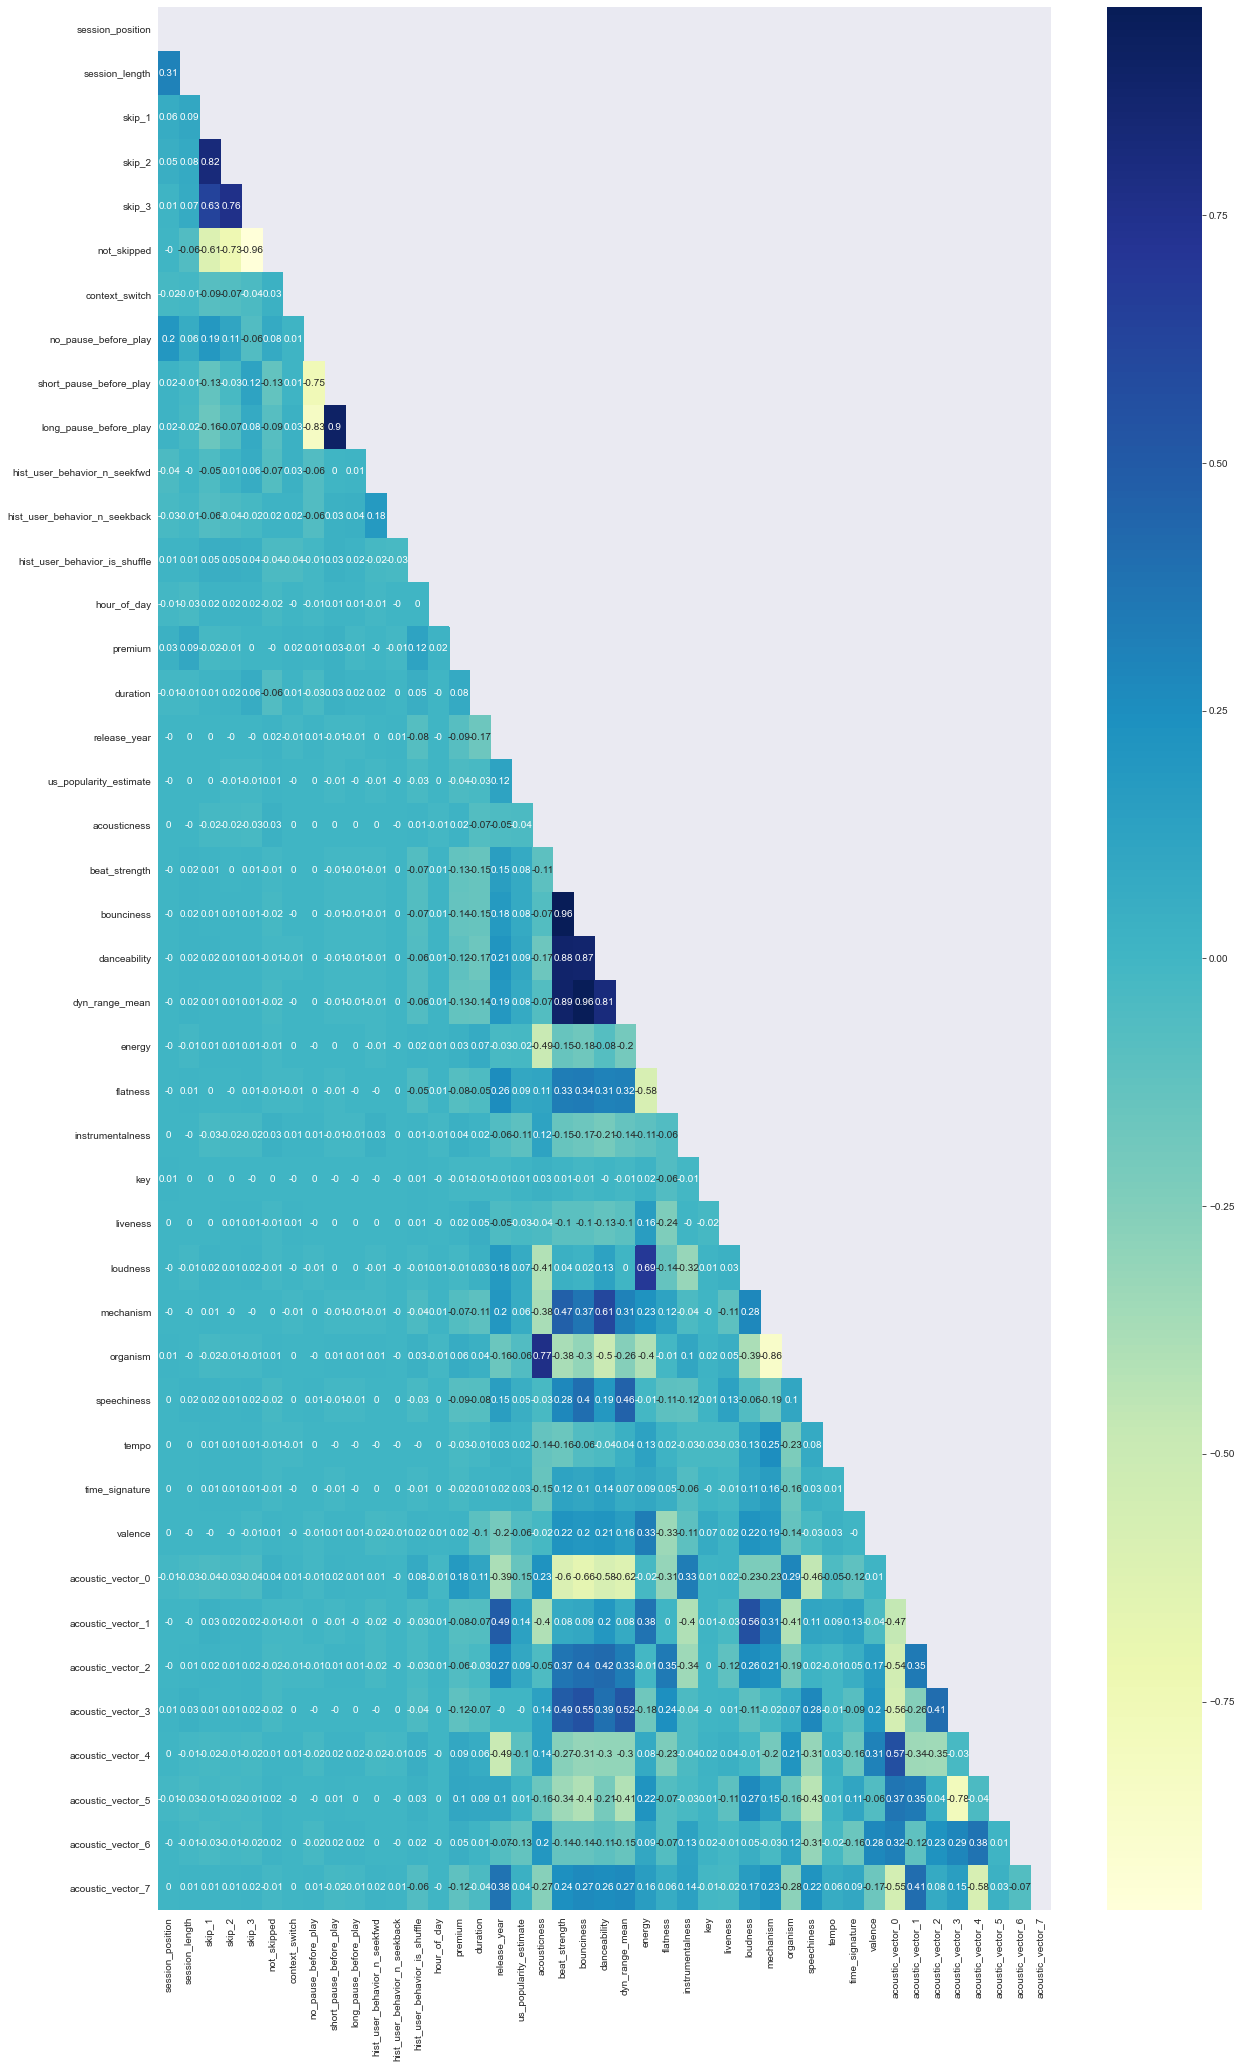

In [12]:
#correlation heatmap
corrchurn = session_df.corr().round(2)
mask = np.zeros_like(corrchurn)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20,35))
sns.heatmap(corrchurn,annot=True,cmap="YlGnBu",mask=mask);

#### Heatmap

The two columns with largest correlation to `skip_2` are `hist_user_behavior_reason_end`, `hist_user_reason_start`, and  `not_skipped`. I do not count `skip_1` and `skip_3` because they are too correlated with `skip_2`. `hist_user_behavior_end` might be too strongly correlated and we won't know how the current track ended when predicting a song that will not be skipped.

In [13]:
# dependent variable class balances
print(session_df['skip_1'].value_counts(normalize=True))
print(session_df['skip_2'].value_counts(normalize=True))
print(session_df['skip_3'].value_counts(normalize=True))

False    0.583351
True     0.416649
Name: skip_1, dtype: float64
True     0.512195
False    0.487805
Name: skip_2, dtype: float64
True     0.642715
False    0.357285
Name: skip_3, dtype: float64


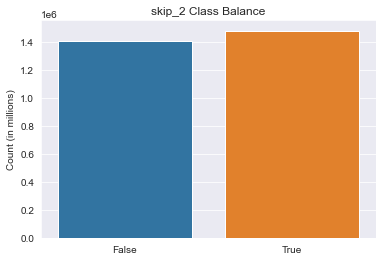

In [14]:
# skip_2 class balance
y = session_df["skip_2"].value_counts()
plt.title('skip_2 Class Balance')
plt.ylabel('Count (in millions)')
sns.barplot(x=y.index,y=y.values);

#### Class imbalance

`skip_2` is a boolean indicating if the track was only played briefly and the recommended dependent variable from the data provider and to be considered as the ground truth. `skip_1` a boolean indicating if the track was only played very briefly and `skip_3` a boolean indicating if most of the track was played have a larger class imbalance. One of the biggest challenges for classification models is an imbalance of classes in the training data. Class imbalance is defined as two populations with unequal proportions. `skip_2` is very close to being a 50-50 split on true or false data points, this will help the models avoid prediction bias.

In [15]:
# drop skip_1 and skip_2
session_df = session_df.drop(['skip_1','skip_3'], axis = 1, inplace = False)

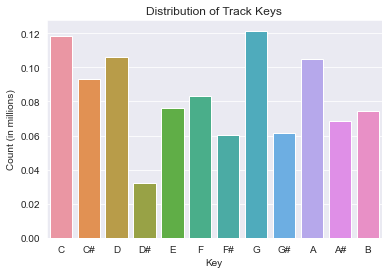

In [16]:
keys = tf_df['key'].value_counts().sort_index()
sns.barplot(
    x=["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"],
    y=keys.values/keys.sum())
plt.title("Distribution of Track Keys")
plt.ylabel('Count (in millions)')
plt.xlabel("Key");

In [17]:
tf_df['key'].value_counts(normalize=True)

7     0.121502
0     0.118193
2     0.106337
9     0.104968
1     0.093346
5     0.083286
4     0.076057
11    0.074213
10    0.068716
8     0.061332
6     0.060077
3     0.031974
Name: key, dtype: float64

Of the 2.9 million songs in the Spotify song data the most popular keys are C, G, D, and A. And by quite a lot the least common key is D# which only accounted for 3.2% of songs. 

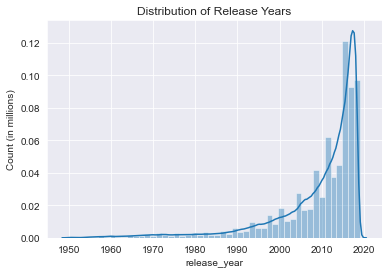

In [18]:
sns.distplot(tf_df['release_year'])
plt.ylabel('Count (in millions)')
plt.title("Distribution of Release Years");

As time progresses more and more songs come out each year. This is likely due to technological advances giving more artists the oppurtunity to produce and release music.

In [19]:
session_df['mode'].value_counts()

major    1782239
minor    1102238
Name: mode, dtype: int64

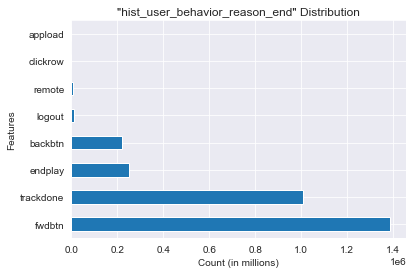

In [20]:
# the user action which led to the current track playback ending
session_df.hist_user_behavior_reason_end.value_counts().plot.barh()
plt.title('"hist_user_behavior_reason_end" Distribution')
plt.ylabel('Features')
plt.xlabel('Count (in millions)')
plt.show();

48% of songs are ended by the user pressing the forward button and 35% of tracks are ended due to the track being played all the way through.

In [21]:
# user reason end features
session_df.hist_user_behavior_reason_end.value_counts(normalize=True)

fwdbtn       0.481215
trackdone    0.350149
endplay      0.087267
backbtn      0.076317
logout       0.003323
remote       0.001710
clickrow     0.000014
appload      0.000004
Name: hist_user_behavior_reason_end, dtype: float64

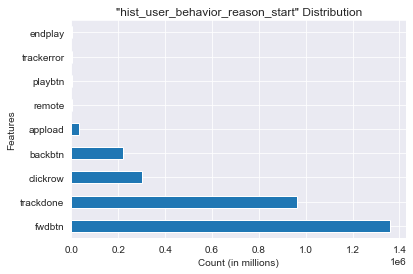

In [22]:
# the user action which led to the current track being played
session_df.hist_user_behavior_reason_start.value_counts().plot.barh()
plt.title('"hist_user_behavior_reason_start" Distribution')
plt.ylabel('Features')
plt.xlabel('Count (in millions)')
plt.show()

47% of songs are started by the user pressing the forward button and 33% of tracks are began due to the previous track being played all the way through. 10% of songs are begun by a user clicking on it.

In [23]:
# user reason start features
session_df.hist_user_behavior_reason_start.value_counts(normalize=True)

fwdbtn        0.471861
trackdone     0.334452
clickrow      0.104074
backbtn       0.075622
appload       0.011477
remote        0.000866
playbtn       0.000835
trackerror    0.000678
endplay       0.000136
Name: hist_user_behavior_reason_start, dtype: float64

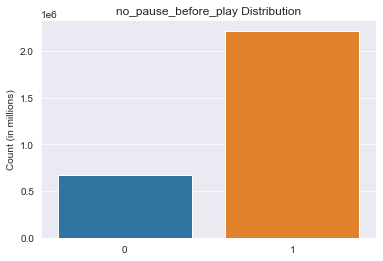

In [24]:
# pause before play distribution
y = session_df["no_pause_before_play"].value_counts()
plt.title('no_pause_before_play Distribution')
plt.ylabel('Count (in millions)')
sns.barplot(x=y.index,y=y.values);

#### Label encode categorical columns

Label encoding is defined as converting the labels into a numeric form so as to convert them into the machine readable form. Machine learning algorithms can then decide how those labels will be used in a more efficient fashion. Label encoding converts the data into a format that the models can read by assigning a unique number(starting from 0) to each class of data. It is a important processing step for the structured dataset in supervised learning.

In [25]:
session_df.dtypes

session_id                          object
session_position                     int64
session_length                       int64
skip_2                                bool
not_skipped                           bool
context_switch                       int64
no_pause_before_play                 int64
short_pause_before_play              int64
long_pause_before_play               int64
hist_user_behavior_n_seekfwd         int64
hist_user_behavior_n_seekback        int64
hist_user_behavior_is_shuffle         bool
hour_of_day                          int64
date                                object
premium                               bool
context_type                        object
hist_user_behavior_reason_start     object
hist_user_behavior_reason_end       object
track_id                            object
duration                           float64
release_year                         int64
us_popularity_estimate             float64
acousticness                       float64
beat_streng

In [26]:
#Label Encoding
label_encoder = preprocessing.LabelEncoder()

session_df['session_id'] = label_encoder.fit_transform(df['session_id'])
session_df['date'] = label_encoder.fit_transform(df['date'])
session_df['context_type'] = label_encoder.fit_transform(df['context_type'])
session_df['hist_user_behavior_reason_start'] = label_encoder.fit_transform(df['hist_user_behavior_reason_start'])
session_df['hist_user_behavior_reason_end'] = label_encoder.fit_transform(df['hist_user_behavior_reason_end'])

In [27]:
# no more objects only numerical data
session_df.dtypes

session_id                           int64
session_position                     int64
session_length                       int64
skip_2                                bool
not_skipped                           bool
context_switch                       int64
no_pause_before_play                 int64
short_pause_before_play              int64
long_pause_before_play               int64
hist_user_behavior_n_seekfwd         int64
hist_user_behavior_n_seekback        int64
hist_user_behavior_is_shuffle         bool
hour_of_day                          int64
date                                 int64
premium                               bool
context_type                         int64
hist_user_behavior_reason_start      int64
hist_user_behavior_reason_end        int64
track_id                            object
duration                           float64
release_year                         int64
us_popularity_estimate             float64
acousticness                       float64
beat_streng

#### Random sample

Random sampling is a practice that selects a sample of units from a population by chance typically to allow generalization from the sample to the population. Random sampling ensures that results obtained from your sample should approximate what would have been obtained if the entire population had been measured. The random sample I ran allows all the units in the population to have an equal chance of being selected. I chose to run a random sample in order to get practical run times.

In [28]:
# Random sample
sample_df = session_df.sample(frac = 0.035)

### Train-Test Split

The train-test split method is used to split our data into train and test sets. I to divided the data into  x (containing the independent variables) and y (which consists of the dependent variable). The dataframe gets divided into X_train, X_test, y_train, and y_test. X_train and y_train sets are used for training and fitting the model. The X_test and y_test sets are used for testing the model if it’s predicting the right outputs.

In [29]:
# declare dependent and independent variables
y = sample_df.skip_2
x = sample_df.drop(['skip_2', 'hist_user_behavior_reason_end',
                    'track_id', 'mode'], axis = 1, inplace = False)

In [30]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25,random_state=42)

### Confusion matrices, ROC plots, and classification repotrts of classifier models

#### Confusion Matrices

The confusion matrix is built to show the percentage of:

* True positives: not skipped songs the classifier labeled as not skipped
* True negatives: skipped songs the classifier labeled as skipped
* False positives: not skipped songs the classifier labeled as skipped
* False negatives: skipped songs the classifier labeled as not skipped

#### ROC Curves

The Receiver Operator Characteristic (ROC) curve is used to assess the classification ability of a classification model, by plotting the true positive rate against the false positive rate. The faster the curve 'peaks', the better the true positive rate without necessarily having very many false positives. AUC stands for "Area under the ROC Curve" AUC measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds. 

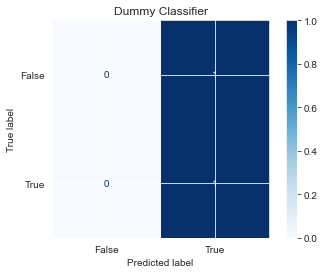

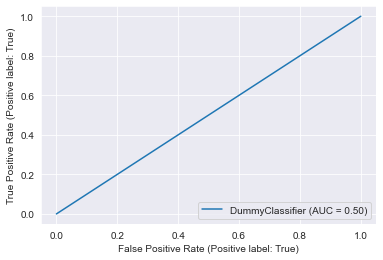

In [31]:
# Dummy classifier
dummy = DummyClassifier()
dummy.fit(x_train, y_train)
metrics.plot_confusion_matrix(dummy,x_train,y_train,cmap='Blues',
                             normalize='true')
title = 'Dummy Classifier'
plt.title(title)
plt.show

metrics.plot_roc_curve(dummy, x_train, y_train)
plt.show();

The DummyClassifier makes predictions that ignore the input features. This classifier serves as a baseline to compare against the other more complex classifiers. My DummyClassifier always picks the most frequent class label in the data.

### Logistic Regression

Logistic regression is a classification technique that uses a logistic function to model the dependent variable. The dependent variable could only be two possible classes (skip or no skip), this means I will be using binomial logistic regression. In order to map out the predicted values to probabilities sigmoid function is used. This function maps any real value into another value between 0 to 1.

In [32]:
#class_weight parameters
params = dict(fit_intercept=True, C=1e12, solver='liblinear')

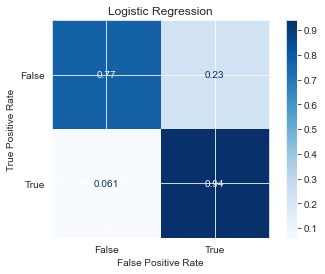

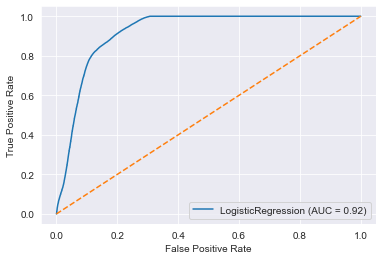

In [33]:
#Logistic Regression
clf_log = LogisticRegression(class_weight='balanced', **params)
clf_log.fit(x_train, y_train)


metrics.plot_confusion_matrix(clf_log,x_train,y_train,cmap='Blues',
                             normalize='true')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'Logistic Regression'
plt.title(title)
plt.show

metrics.plot_roc_curve(clf_log, x_train, y_train)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [34]:
# train classificaction report
y_pred = clf_log.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print('TRAIN CLASSIFICATION REPORT:')
print(classification_report(y_train, y_pred))

[[28607  8394]
 [ 2354 36362]]
TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.92      0.77      0.84     37001
        True       0.81      0.94      0.87     38716

    accuracy                           0.86     75717
   macro avg       0.87      0.86      0.86     75717
weighted avg       0.87      0.86      0.86     75717



In [35]:
# test classification report
y_pred = clf_log.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

[[ 9401  2854]
 [  754 12231]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.93      0.77      0.84     12255
        True       0.81      0.94      0.87     12985

    accuracy                           0.86     25240
   macro avg       0.87      0.85      0.86     25240
weighted avg       0.87      0.86      0.86     25240



#### Research Metrics 

For my analysis of the classifiers I will be using the precision, recall, and the f1-score metrics in unison. Precision measures how precise the predictions are, while recall indicates what percentage of the classes being evaluated were actually captured by the model. Precision is highly sensitive to false positives and recall is very sensitive to false negatives and f1-score is a mean of recall and precision. 

#### Results

The report shows the model actually performed pretty well. I ran multiple logistic regression classifiers to test different parameters and found the final selection gave me the best results. The logistic regression model has a small bias towards predicting no skip but is very accurate at predicting if the song will be skiped. These results while promising are still unsatisfactory because while it is important to know if a song will be skipped it is more valuable to know which songs will not be skipped.

### K-Nearest Neighbors (KNN)

K-nearest neighbors (KNN) is a type of supervised learning algorithm used for both regression and classification. KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then the model selects the K number of points which is closet to the test data. The KNN algorithm calculates the probability of the test data belonging to the classes of ‘K’ training data and class holds the highest probability will be selected.

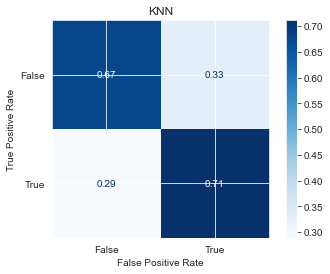

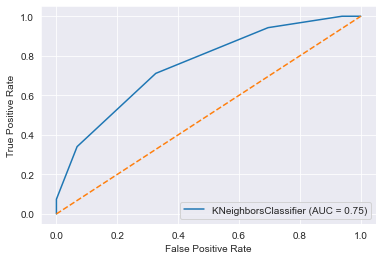

In [36]:
#K Nearest Neighbors
clf_knn = KNeighborsClassifier()
clf_knn.fit(x_train, y_train)
metrics.plot_confusion_matrix(clf_knn,x_train,y_train,cmap='Blues',
                             normalize='true')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'KNN'
plt.title(title)
plt.show

metrics.plot_roc_curve(clf_knn, x_train, y_train)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [37]:
# train classificaction report
y_pred = clf_knn.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print('TRAIN CLASSIFICATION REPORT:')
print(classification_report(y_train, y_pred))

[[24922 12079]
 [11189 27527]]
TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.69      0.67      0.68     37001
        True       0.70      0.71      0.70     38716

    accuracy                           0.69     75717
   macro avg       0.69      0.69      0.69     75717
weighted avg       0.69      0.69      0.69     75717



In [38]:
# test classification report
y_pred = clf_knn.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

[[5879 6376]
 [6006 6979]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.49      0.48      0.49     12255
        True       0.52      0.54      0.53     12985

    accuracy                           0.51     25240
   macro avg       0.51      0.51      0.51     25240
weighted avg       0.51      0.51      0.51     25240



#### Results

The report says this model performed very poorly. The training set predictions were decent but when compared to the test set it's clear the classifier was overfit to the training set. The KNN classifier performed about the same when predicting skip or no skip. I only ran a few iterations of the KNN and did not change much (only the data)  because one of the advantages of a KNN classifier is there’s no need to  tune several parameters or make additional assumptions. 

### Random Forest

The Random forest algorithm is a supervised learning algorithm that can be used for both classification and regression analysis. Random forest consists of a large number of individual decision trees that operate as an ensemble. Ensemble learning methods are made up of a set of classifiers and their predictions are designed to identify the most popular result.

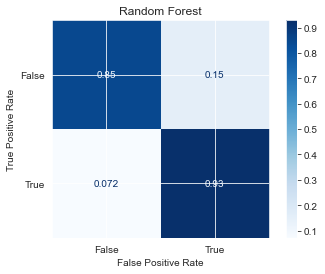

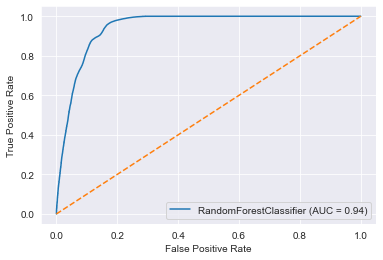

In [39]:
#Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, max_depth= 10)
clf_rf.fit(x_train, y_train)
metrics.plot_confusion_matrix(clf_rf,x_train,y_train,cmap='Blues',
                             normalize='true')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'Random Forest'
plt.title(title)
plt.show

metrics.plot_roc_curve(clf_rf, x_train, y_train)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [40]:
#Grid search for Random Forest model
param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 7, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}
grid_search = GridSearchCV(clf_rf, param_grid, cv=3)
grid_search.fit(x_train, y_train)
print(f"Training Accuracy: {grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid_search.best_params_}")

Training Accuracy: 86.67%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}


#### Grid Search

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an extensive search that is performed on specific parameter values of a model. My gridsearch helped improve the no skip recommendation. The recommended hyperparameters increased the overall precision and recall by 0.03 points on training set.

In [41]:
# train classificaction report
y_pred = clf_rf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print('TRAIN CLASSIFICATION REPORT:')
print(classification_report(y_train, y_pred))

[[31313  5688]
 [ 2776 35940]]
TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.92      0.85      0.88     37001
        True       0.86      0.93      0.89     38716

    accuracy                           0.89     75717
   macro avg       0.89      0.89      0.89     75717
weighted avg       0.89      0.89      0.89     75717



In [42]:
# test classification report
y_pred = clf_rf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

[[10134  2121]
 [ 1212 11773]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.89      0.83      0.86     12255
        True       0.85      0.91      0.88     12985

    accuracy                           0.87     25240
   macro avg       0.87      0.87      0.87     25240
weighted avg       0.87      0.87      0.87     25240



#### Results

The report shows the random forest classifier performed great. There was minimal error when predicting skip and this I got the best results when predicting no skip with the grid searched random forest model. The model is fit well to the data and I got very similar performance on the training set and the test set. This model had the highest precision, recall, and f1-scores out of the whole project.

### Gradient Boosting

Gradient boosting is a ensemble method where you create multiple weak models and combine them to get better performance as a whole. It gives a prediction in the form of an ensemble of weak prediction models, which are typically decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient boosted trees. These models usually outperforms random forest.

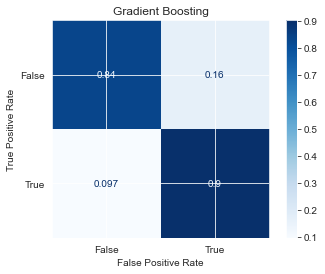

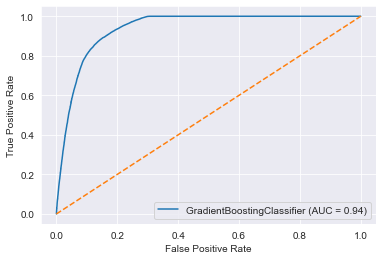

In [43]:
#Gradient Boosting
clf_gbc = ensemble.GradientBoostingClassifier(random_state=42)
clf_gbc.fit(x_train, y_train)
metrics.plot_confusion_matrix(clf_gbc,x_train,y_train,cmap='Blues',
                             normalize='true')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
title = 'Gradient Boosting'
plt.title(title)
plt.show

metrics.plot_roc_curve(clf_gbc, x_train, y_train)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [44]:
# train classificaction report
y_pred = clf_gbc.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print('TRAIN CLASSIFICATION REPORT:')
print(classification_report(y_train, y_pred))

[[30905  6096]
 [ 3771 34945]]
TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.89      0.84      0.86     37001
        True       0.85      0.90      0.88     38716

    accuracy                           0.87     75717
   macro avg       0.87      0.87      0.87     75717
weighted avg       0.87      0.87      0.87     75717



In [45]:
# test classification report
y_pred = clf_gbc.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

[[10167  2088]
 [ 1273 11712]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       False       0.89      0.83      0.86     12255
        True       0.85      0.90      0.87     12985

    accuracy                           0.87     25240
   macro avg       0.87      0.87      0.87     25240
weighted avg       0.87      0.87      0.87     25240



#### Results

The report shows the gradient boosting classifier performed well. I ran multiple gradient boosting classifiers to test different parameters and found the final selection gave me the best results. The model is fit well to the data and I got very similar performance on the training set and the test set. This model had the second highest precision, recall, and f1-scores out of the whole project very close to the scores of the random forest classifier.

### Feature Importance

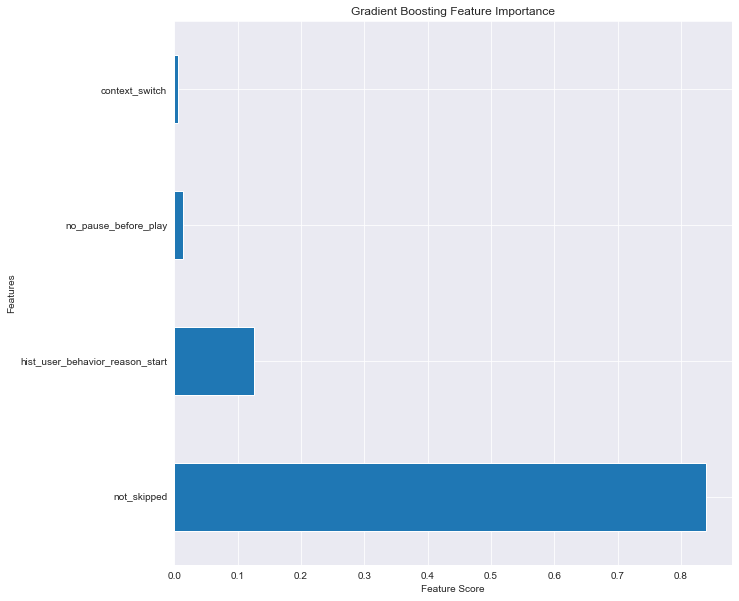

In [51]:
# Gradient Boosting feature importance
feature_importance = clf_gbc.feature_importances_
feat_importances = pd.Series(clf_gbc.feature_importances_, 
                             index=x.columns)
feat_importances = feat_importances.nlargest(4)
feat_importances.plot(kind='barh' , figsize=(10,10))
plt.title('Gradient Boosting Feature Importance')
plt.ylabel('Features')
plt.xlabel('Feature Score');

The features with the highest feature importance score for the gradient boosting classifier are `not_skipped`, `hist_user_behavior_start`, and `no_pause_before_play`. `not_skipped` was by far and away the highest scored feature by the gradient boosting classifier. This model is saying the most important thing to know when recommending songs is whether or not the previously played song was skipped.

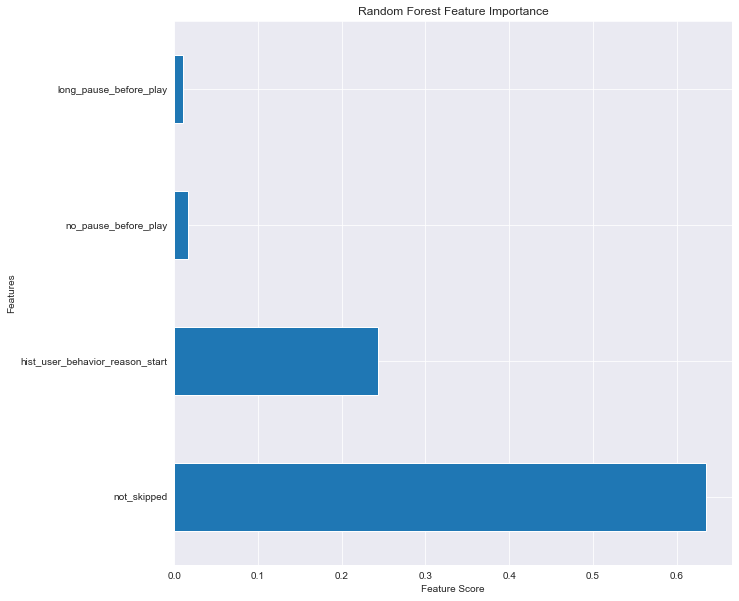

In [52]:
# Random Forest feature importance
feature_importance = clf_rf.feature_importances_
feat_importances = pd.Series(clf_rf.feature_importances_, 
                             index=x.columns)
feat_importances = feat_importances.nlargest(4)
feat_importances.plot(kind='barh' , figsize=(10,10))
plt.title('Random Forest Feature Importance')
plt.ylabel('Features')
plt.xlabel('Feature Score');

The features with the highest feature importance score for the random forest classifier are also `not_skipped`, `hist_user_behavior_start`, and `no_pause_before_play` with the same exact placement as the gradient boosting classifier and similar scores. The random forest classifier is also saying the most important thing to know when recommending songs is whether or not the previously played song was skipped.

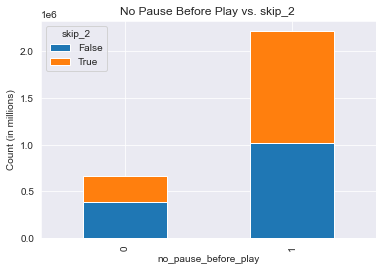

In [48]:
# no pause before play and skip_2
df.groupby(["no_pause_before_play", "skip_2"]).size().unstack().plot(kind='bar', stacked=True)
plt.title('No Pause Before Play vs. skip_2 ')
plt.ylabel('Count (in millions)');

Whether or not the user skips looks pretty even in the `no_pauses_before_play` data.

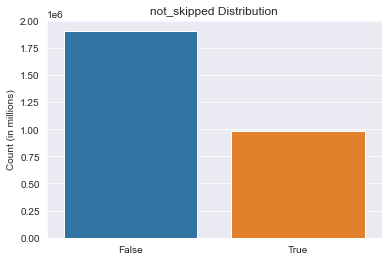

In [49]:
# not_skipped distribution
y = session_df["not_skipped"].value_counts()
plt.title('not_skipped Distribution')
plt.ylabel('Count (in millions)')
sns.barplot(x=y.index,y=y.values);

In [50]:
session_df.not_skipped.value_counts(normalize=True)

False    0.66078
True     0.33922
Name: not_skipped, dtype: float64

It is more likely a user skips a song than play it all te way through  with almost two thirds of all songs being skipped.

## Conclusion

* Random forest was the best performing classifier and the most important features are `not_skipped`, `hist_user_behavior_start`, and `no_pause_before_play`.

* The classifier is saying the most important features deal with user behavior much more than the track features (like `key` or `release_year`). I recommend Spotify evaluate when a user is skipping a lot and either play songs already in the user's library or play something very different than the recently skipped tracks.

* According to the best performing classifiers the most important factor when predicting skip is `not_skipped`, 66% of songs played are skipped.

* The second most important feature is `hist_user_behavior_start` 47% of songs are begun by a user hitting the forward button and 33% of songs are started by the last song playing all the way through.

#### Next Steps

* Host the project online instead of Jupyter Notebook in order to be able to utilize the entire dataset

* Run a broader grid search on the random forest to see if there are more optimal hyperparameters

* Utilize a sklearn scaler like MinMaxScaler() to optimize the scale and distribution of the data

### Thank You